In [91]:
#importing some useful packages
import matplotlib.pyplot as plt #To plot lines
import matplotlib.image as mpimg #To read images
import numpy as np #To work with images as matrices
import cv2 #For canny, Hough, and so many work
import math #Used for ROI
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip, clips_array
from IPython.display import HTML
import time
import os
#For plotting images inline:
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


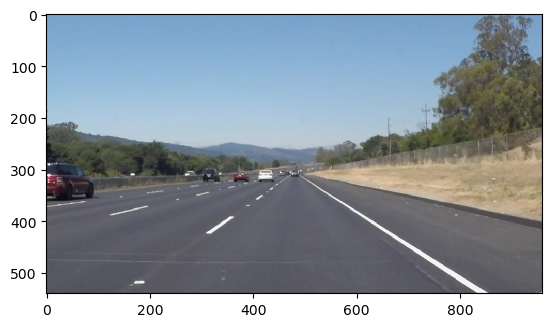

In [92]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

# Helper Function

In [135]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices): #recieves vertices as np.array([[(w1, h1), (w2, h2), (w3, h3)]])
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, roiImage, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, roiImage)
    return line_img, lines

def draw_lines(img, lines, roiImage, color=[0, 0, 255], thickness=10):
    left_points = []
    right_points = []
    width = img.shape[1]
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if (roiImage[y1, x1].any() > 0) and (roiImage[y2, x2].any() > 0):
                # Determine if points are on the left or right side
                if x1 < width // 2 and x2 < width // 2:
                    left_points.append((x1, y1))
                    left_points.append((x2, y2))
                elif x1 >= width // 2 and x2 >= width // 2:
                    right_points.append((x1, y1))
                    right_points.append((x2, y2))
    
    # Find the highest and lowest points on the left
    if left_points:
        left_points.sort(key=lambda point: point[1])
        highest_left_point = left_points[0]
        lowest_left_point = left_points[-1]
        # Draw the left line
        cv2.line(img, highest_left_point, lowest_left_point, color, thickness)
    
    # Find the highest and lowest points on the right
    if right_points:
        right_points.sort(key=lambda point: point[1])
        highest_right_point = right_points[0]
        lowest_right_point = right_points[-1]
        # Draw the right line
        cv2.line(img, highest_right_point, lowest_right_point, color, thickness)

def weighted_img(img, initial_img, α=0.9, β=1., γ=0.):

    return cv2.addWeighted(initial_img, α, img, β, γ)

def process_image(image):
    #Sequence of image processing -> from input image from the video to image with lane lines drawn
    height, width = image.shape[:2]
    gray = grayscale(image)
    cannyOutput = canny(gray, 75, 150)
    roi = region_of_interest(image, np.array([[(480, 305),(20, 539),(width-20, 539)]]))
    houghImage, lines = hough_lines(cannyOutput, roi, 2, np.pi/180, 5, 15, 10)
    result = weighted_img(houghImage, image)
    return result

def display_clip(video_path, window_title='Video'):
    # Create a VideoCapture object
    cap = cv2.VideoCapture(video_path)

    # Check if the video opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
        exit()

    while True:
        # Read a frame from the video
        ret, frame = cap.read()

        # If frame is read correctly, display it
        if ret:
            cv2.imshow(window_title, frame)
        else:
            break

        # Wait for 30 ms before moving to the next frame
        # Press 'q' to exit the loop
        if cv2.waitKey(30) & 0xFF == ord('q'):
            break

    # Release the VideoCapture object and close all OpenCV windows
    cap.release()
    cv2.destroyAllWindows()

def combineVideos(video1_path, video2_path, output_path):
    # Load videos
    video1 = VideoFileClip(video1_path)
    video2 = VideoFileClip(video2_path)

    # Ensure both videos have the same width
    width = min(video1.w, video2.w)
    video1 = video1.resize(width=width)
    video2 = video2.resize(width=width)

    # Combine the two videos vertically
    combined_clip = clips_array([[video1], [video2]])

    # Determine the size of the square window
    max_height = video1.h + video2.h
    max_width = video1.w + video2.w
    square_size = max(max_width/2, max_height/2)

    # Resize the combined video to fit in a square window
    combined_clip = combined_clip.resize(height=square_size)

    # Write the result to a file
    combined_clip.write_videofile(output_path, codec='libx264')



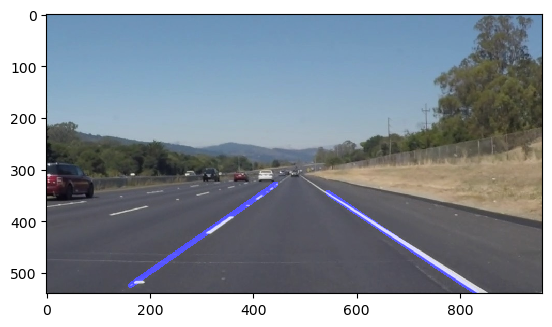

In [136]:
output = process_image(image)
plt.imshow(output)

In [137]:
#Displaying input video
clip1Path = "test_videos/solidWhiteRight.mp4"
display_clip(clip1Path, 'Input Video (Solid White Right)')

In [138]:
#Processing video
clip1 = VideoFileClip(clip1Path)
white_output = 'test_videos_output/solidWhiteRight.mp4'
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 3.75 s, sys: 355 ms, total: 4.11 s
Wall time: 3.57 s


In [139]:
#Displaying output video
display_clip(white_output, 'Output Video (Solid White Right)')

In [140]:
#Combine videos side by side 
combinedPath = 'combined_videos/solidWhiteRight.mp4'
combineVideos(clip1Path, white_output, combinedPath)

Moviepy - Building video combined_videos/solidWhiteRight.mp4.
MoviePy - Writing audio in solidWhiteRightTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video combined_videos/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready combined_videos/solidWhiteRight.mp4


In [143]:
#Display Combined video
display_clip(combinedPath, 'Combined Video [solidWhiteRight]')

In [144]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2Path = 'test_videos/solidYellowLeft.mp4'
clip2 = VideoFileClip(clip2Path)
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 12.4 s, sys: 851 ms, total: 13.3 s
Wall time: 10.9 s


In [146]:
combinedPath2 = 'combined_videos/solidYellowLeft.mp4'
combineVideos(clip2Path, yellow_output, combinedPath2)
#Display Combined video
display_clip(combinedPath2, 'Combined Video [solidYellowLeft]')

Moviepy - Building video combined_videos/solidYellowLeft.mp4.
MoviePy - Writing audio in solidYellowLeftTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video combined_videos/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready combined_videos/solidYellowLeft.mp4
